# **Introduction**

Online payment is the most popular transaction method in the world today. However, with an increase in online payments also comes a rise in payment fraud. The objective of this study is **to identify fraudulent and non-fraudulent payments**. The dataset is collected from Kaggle, which contains historical information about fraudulent transactions which can be used to detect fraud in online payments. 


The dataset consists of 10 variables:
* **step**: represents a unit of time where 1 step equals 1 hour
* **type**: type of online transaction
* **amount**: the amount of the transaction
* **nameOrig**: customer starting the transaction
* **oldbalanceOrg**: balance before the transaction
* **newbalanceOrig**: balance after the transaction
* **nameDest**: recipient of the transaction
* **oldbalanceDest**: initial balance of recipient before the transaction
* **newbalanceDest**: the new balance of recipient after the transaction
* **isFraud**: fraud transaction

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
from tabulate import tabulate

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
df = pd.read_csv('/kaggle/input/online-payment-fraud-detection/onlinefraud.csv')

df.drop('isFlaggedFraud', axis=1, inplace=True)

df.info()

ParserError: Error tokenizing data. C error: Expected 1 fields in line 9, saw 2


* The dataset consists of 6,362,620 observations.

In [3]:
df.sample(5)

NameError: name 'df' is not defined

In [4]:
df.isnull().sum()

NameError: name 'df' is not defined

* There are no missing values.

In [5]:
fraud_min_max = [
    ['amount', df.amount.min(), df.amount.max()],
    ['oldbalanceOrg', df.oldbalanceOrg.min(), df.oldbalanceOrg.max()],
    ['newbalanceOrig', df.newbalanceOrig.min(), df.newbalanceOrig.max()],
    ['oldbalanceDest', df.oldbalanceDest.min(), df.oldbalanceDest.max()],
    ['isFraud', df.isFraud.min(), df.isFraud.max()]
] 

print(
    tabulate(
        fraud_min_max,
        headers=['columns', 'min value', 'max value'],
        showindex=True,
        tablefmt='github',
        numalign='right'
    )
)

|    | columns        |   min value |   max value |
|----|----------------|-------------|-------------|
|  0 | amount         |           0 | 9.24455e+07 |
|  1 | oldbalanceOrg  |           0 |  5.9585e+07 |
|  2 | newbalanceOrig |           0 |  4.9585e+07 |
|  3 | oldbalanceDest |           0 | 3.56016e+08 |
|  4 | isFraud        |           0 |           1 |


In [6]:
# Downcast numerical columns with smaller dtype
for col in df.columns:
    if df[col].dtype == 'float64':
        df[col] = pd.to_numeric(df[col], downcast='float')
    if df[col].dtype == 'int64':
        df[col] = pd.to_numeric(df[col], downcast='unsigned')

# Use category dtype for categorical column
df['type'] = df['type'].astype('category')

In [7]:
# Check duplicate values
df.duplicated().sum()

0

* There are no duplicate values.

# Exploratory Data Analysis

In [8]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (8,6)

## Univariate analysis

In [9]:
df.describe()

step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338834e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888242e+06    2.924048e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06  
mean     1.100702e+06    1.224997e+06  1.290820e-03  
std      3.399180e+06    3.674129e+06  3.590480e-02  
min      0.000000e+00    0.000000e+00  0.000000e+00  
25%      0.000000e+00    0.000000e+00  0.000000e+00  
50%      1.327057e+05    2.146614e+05  0.000000e+00  
75%      9.430367e+05    1.111909e+06  0.000000e+00  
max      3.560159e+08    3.561793e+08  1.000000e+00

In [10]:
df['step'].value_counts()

19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
432        4
706        4
693        4
112        2
662        2
Name: step, Length: 743, dtype: int64

* There are **743** steps, and every step has **at least 2** occurrences.

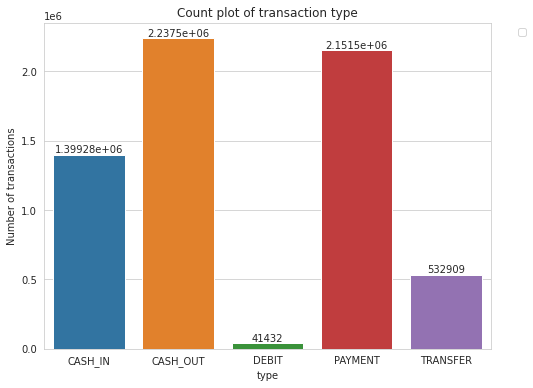

In [11]:
ax = sns.countplot(x='type', data=df)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of transaction type', fontsize=12)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')

del ax

* **Cash out** is **the most numerous** transaction type, followed by payment, cash in, transfer and debit types.

Text(0.5, 1.0, 'Distribution of transaction amount')

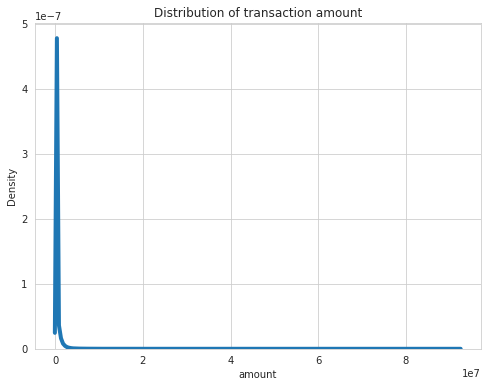

In [12]:
sns.kdeplot(df['amount'], linewidth=4)
plt.title('Distribution of transaction amount')

* The distribution of transaction amounts is **right skewed**. 
* This indicates that most values are clustered around the left tail of the distribution, with the longer right tail. 
* (mode < median < mean)

In [13]:
df['nameOrig'].value_counts()

C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: nameOrig, Length: 6353307, dtype: int64

* There are **6353307** initial customers, and every step has **at least 1** occurrence.

Text(0.5, 1.0, 'Distribution of transaction amount')

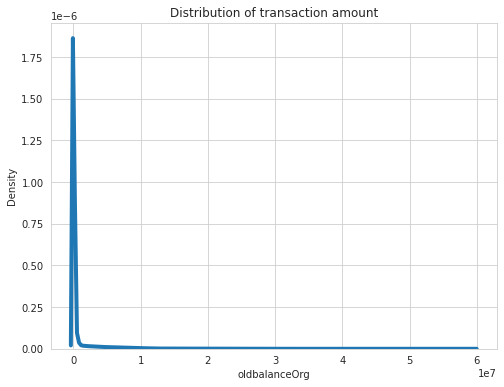

In [14]:
sns.kdeplot(df['oldbalanceOrg'], linewidth=4)
plt.title('Distribution of transaction amount')

* The distribution of pre-transaction balances of the initial customers is **right skewed**.

Text(0.5, 1.0, 'Distribution of transaction amount')

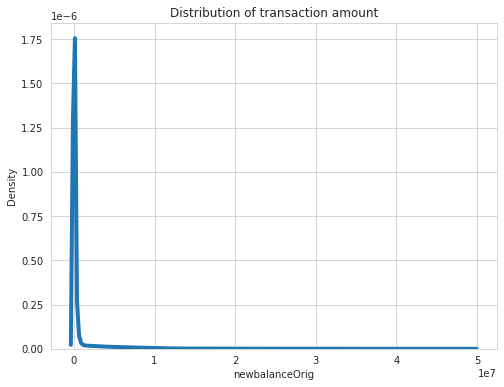

In [15]:
sns.kdeplot(df['newbalanceOrig'], linewidth=4)
plt.title('Distribution of transaction amount')

* The distribution of post-transaction balances of the initial customers is **right skewed**.

In [16]:
df['nameDest'].value_counts()

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: nameDest, Length: 2722362, dtype: int64

* There are **2722362** recipients, and every step has **at least 1** occurrence.

Text(0.5, 1.0, 'Distribution of transaction amount')

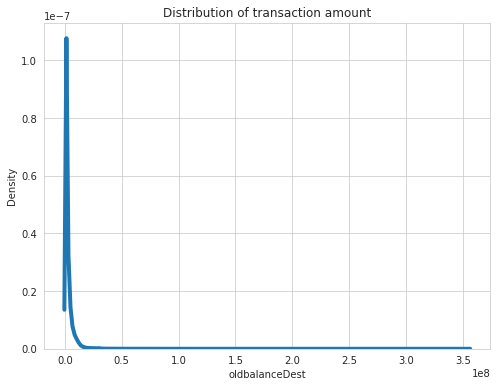

In [17]:
sns.kdeplot(df['oldbalanceDest'], linewidth=4)
plt.title('Distribution of transaction amount')

* The distribution of pre-transaction balances of the recipient is **right skewed**.

Text(0.5, 1.0, 'Distribution of transaction amount')

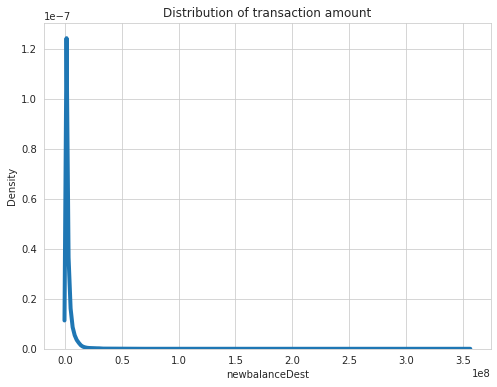

In [18]:
sns.kdeplot(df['newbalanceDest'], linewidth=4)
plt.title('Distribution of transaction amount')

* The distribution of post-transaction balances of the recipient is **right skewed**.

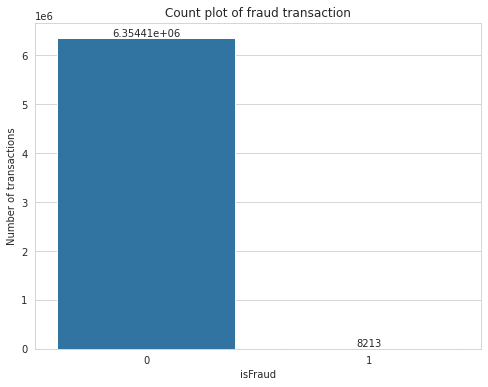

In [19]:
ax = sns.countplot(x='isFraud', data=df)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of fraud transaction', fontsize=12)
plt.ylabel('Number of transactions')

del ax

* There are much **more non-fraudulent transactions** than fraudulent transactions.

## Bivariate analysis

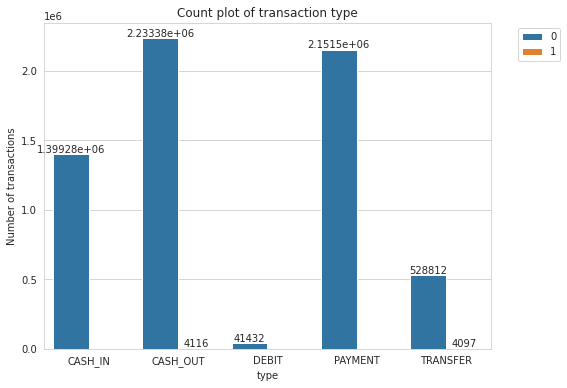

In [20]:
ax = sns.countplot(x='type', data=df, hue='isFraud')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of transaction type', fontsize=12)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')

del ax

* Fraudulent transactions only occur in debit and transfer types.

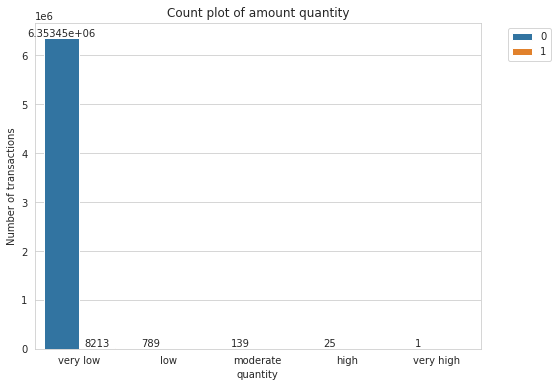

In [21]:
df['quantity'] = pd.cut(df['amount'], 5, labels=['very low', 'low', 'moderate', 'high', 'very high'])

ax = sns.countplot(x='quantity', data=df, hue='isFraud')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of amount quantity', fontsize=12)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')

del ax

* All fraudulent transactions fall into the category of very low amounts. 
* This suggests that in most cases, small transactions are more prone to fraudulent transactions.

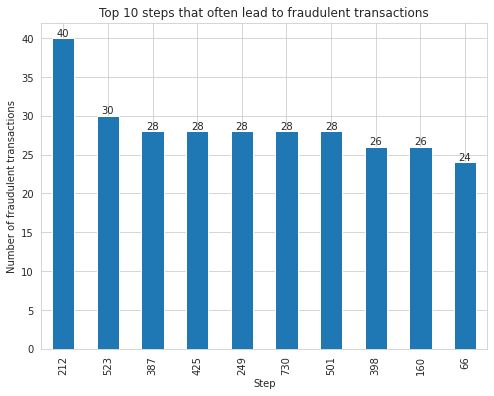

In [22]:
df1 = df[df['isFraud']==1]
df2 = df1['step'].value_counts().head(10)
ax = df2.plot(kind='bar')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 10 steps that often lead to fraudulent transactions', fontsize=12)
plt.ylabel('Number of fraudulent transactions')
plt.xlabel('Step')

del ax, df2

* **Step 212** has the highest number of fraudulent transactions, 40 cases. 
* This indicates that Step 212 is the step that will most likely lead to fraudulent transactions.

Text(0.5, 0, 'Initial customers pre-transaction balance amount')

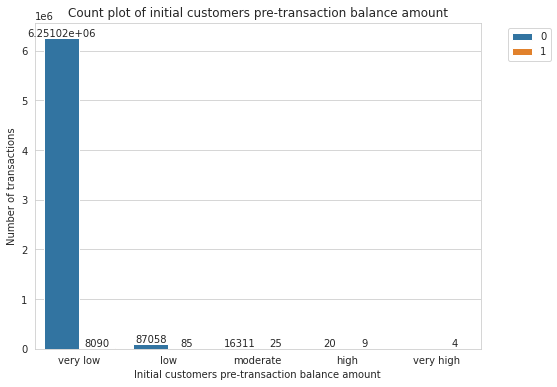

In [23]:
df['oldbalanceOrg_amt'] = pd.cut(df['oldbalanceOrg'], 5, labels=['very low', 'low', 'moderate', 'high', 'very high'])

ax = sns.countplot(x='oldbalanceOrg_amt', data=df, hue='isFraud')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of initial customers pre-transaction balance amount', fontsize=12)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')
plt.xlabel('Initial customers pre-transaction balance amount')

* Initial customers with **very low pre-transaction balances** has the highest number of fraudulent transactions. 
* This means that initial customers with very low pre-transaction balances may be more likely to fall for a fraudulent transaction.

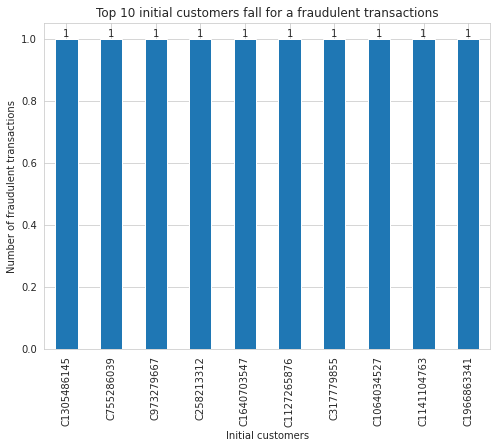

In [24]:
df2 = df1['nameOrig'].value_counts().head(10)
ax = df2.plot(kind='bar')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 10 initial customers fall for a fraudulent transactions', fontsize=12)
plt.ylabel('Number of fraudulent transactions')
plt.xlabel('Initial customers')

del ax, df2

* Initial customers are scammed of **at most one** for a fraudulent transaction.

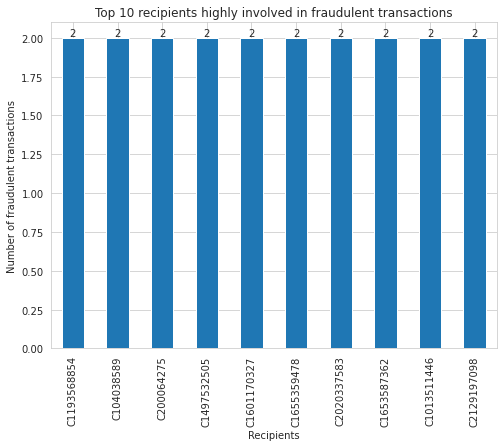

In [25]:
df2 = df1['nameDest'].value_counts().head(10)
ax = df2.plot(kind='bar')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 10 recipients highly involved in fraudulent transactions', fontsize=12)
plt.ylabel('Number of fraudulent transactions')
plt.xlabel('Recipients')

del ax, df2

* Suspicious recipients only have a **maximum of 2** involved fraudulent transactions.

Text(0.5, 0, 'Recipient pre-transaction balance amount')

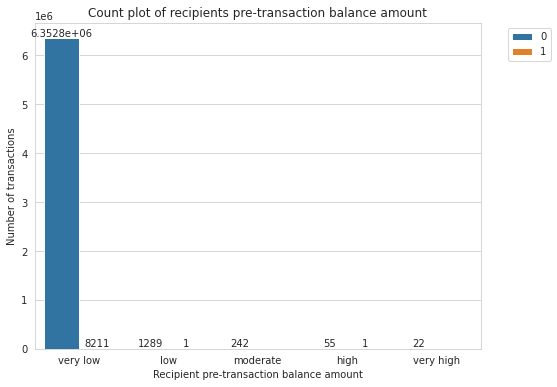

In [26]:
df['oldbalanceDest_amt'] = pd.cut(df['oldbalanceDest'], 5, labels=['very low', 'low', 'moderate', 'high', 'very high'])

ax = sns.countplot(x='oldbalanceDest_amt', data=df, hue='isFraud')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of recipients pre-transaction balance amount', fontsize=12)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')
plt.xlabel('Recipient pre-transaction balance amount')

* Recipients with **very low pre-transaction balances** has the highest number of fraudulent transactions. 
* This implies that recipients with very low pre-transaction balances may be more susceptible to fraudulent transactions.

## Multivariate analysis

Text(0.5, 1.0, 'Correlation')

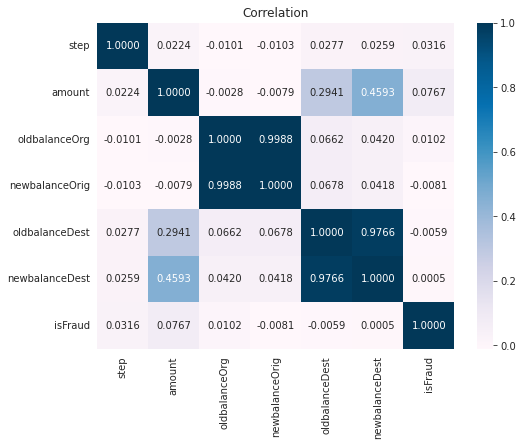

In [27]:
sns.heatmap(df.corr(), cbar=True, fmt='.4f', annot=True, cmap=plt.cm.PuBu)
plt.title('Correlation', fontsize=12)

* oldbalanceOrg and newbalanceOrig has **strong positive** relationship. 
* oldbalanceDest and newbalanceDest has **strong positive** relationship.
* oldbalanceOrg and amount has **weak positive** relationship.
* newbalanceOrig and amount has **moderate positive** relationship.

# Model Building

Due to the large dataset, Random Forest and Naive Bayes will be used to identify online payment fraud.

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X = df[['step', 'type', 'amount', 'oldbalanceOrg', 'oldbalanceDest']]
y = df[['isFraud']]
y = np.squeeze(y)

X = pd.get_dummies(data=X, prefix='type')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.70, random_state=1)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

In [29]:
models = {}

models['Random Forest'] = RandomForestClassifier(n_estimators=10)
models['Naive Bayes'] = GaussianNB()


accuracy, precision, recall, f1 = {}, {}, {}, {}

for key in models.keys():
    models[key].fit(X_train, y_train)
    pred = models[key].predict(X_valid)
    
    accuracy[key] = accuracy_score(pred, y_valid)
    precision[key] = precision_score(pred, y_valid)
    recall[key] = recall_score(pred, y_valid)
    f1[key] = f1_score(pred, y_valid)


In [30]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1'])

df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['F1'] = f1.values()

df_model

Accuracy  Precision   Recall        F1
Random Forest  0.999530   0.681524  0.93757  0.789301
Naive Bayes    0.567733   0.999190  0.00298  0.005942

# Conclusion
* Random Forest obtains highest score among all scores.
* The best performing model is **Random Forest** for identifying fraudulent and non-fraudulent payments.